In [1]:
import torch
import numpy as np
from torch.func import jacrev
import matplotlib.pyplot as plt
import time
import scipy as sp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from scipy.sparse import csc_matrix
import pandas as pd
print(device)

cuda


In [2]:
c1 = 6.2283e-3
c2 = 1.0
c3 = 5.5146
Days = 400
Nx = 15
Ny = 15
dx = torch.tensor(30.0).to(device = device)
dy = torch.tensor(30.0).to(device = device)
dz = torch.tensor(30.0).to(device = device)
Vij = dx*dy*dz
dt = 1
pi = torch.pi
Pref = torch.tensor(2800.0).to(device = device)
Pi = torch.tensor(3000.0).to(device = device)
Swi = 0.2
Soi = 0.8
Co = torch.tensor(1e-5).to(device = device)
Cw = torch.tensor(3e-6).to(device = device)
Cr = torch.tensor(3e-6).to(device = device)
Swmin = torch.tensor(0.1).to(device = device)
Somin = torch.tensor(0.2).to(device = device)
Swmax = 1 - Somin
Somax = 1 - Swmin
Krw_ = torch.tensor(0.08).to(device = device)
Kro_ = torch.tensor(0.7).to(device = device)
rw = torch.tensor(0.35).to(device = device)
re = 0.14*torch.sqrt(dx**2 + dy**2).to(device = device)
mu_w_ = torch.tensor(1.0).to(device = device)
BHP = torch.tensor(2900.0).to(device = device)
QinjW = torch.tensor(300.0).to(device = device)
QinjO = torch.tensor(0.0).to(device = device)
phi = 0.2
S = torch.tensor(0.0).to(device = device)
Well_Loc = torch.zeros(2,Ny, Nx).to(device = device)
Well_Loc[0][0, 0] = 1.0
Well_Loc[1][14, 14] = 1.0
K = np.genfromtxt(r'C:\Users\YUSIFOH\NNs\2D_2PHASE_FLOW_JAC\permx.dat', dtype=None, delimiter=',')
K = K.reshape((15,15))
K = torch.tensor(K, device=device)

steps = int(1 + Days/dt)
P_ = torch.zeros(steps, 15, 15).to(device = device)
P_[0] = torch.ones(15,15, device=device)*Pi
Sw_ = torch.zeros(steps, 15, 15).to(device = device)
Sw_[0] = torch.ones(15, 15, device=device)*Swi

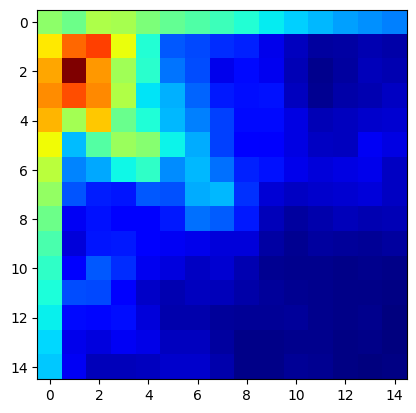

In [3]:
plt.imshow(K.cpu().numpy(), cmap = 'jet')
plt.show()

In [232]:
# MEDIA PROPERTIES:
def porosity(P):
    return phi*torch.exp(Cr*(P - Pref))

# OIL PROPERTIES
def Bo(P, Co, Pref):
    return 0.9871*torch.exp(-Co*(P - Pref))

def mu_o(P, Co, Pref):
    return 1.0127*torch.exp(-5*Co*(P - Pref))

Kr1 = torch.rand(Ny, Nx, device = device)
def Kro(Sw, Somin, Somax, Swmin, Kr1):
    So = 1 -Sw
    mask1 = So >= Somax
    mask2 = So <= Somin
    Kr1[mask1] = Kro_
    Kr1[mask2] = torch.tensor(0.0)
    Kr1 = Kro_*((So - Somin)/(1 - Somin - Swmin))**3
    return Kr1

# WATER PROPERTIES
def Bw(P, Cw, Pref):
    return torch.exp(-Cw*(P - Pref))

def mu_w(P, Cw, Pref):
    return mu_w_

Kr2 = torch.rand(Ny, Nx, device = device)
def Krw(Sw, Swmin, Swmax, Somin, Kr2):
    mask1 = Sw >= Swmax
    mask2 = Sw <= Swmin
    Kr2[mask1] = Krw_
    Kr2[mask2] = torch.tensor(0.0)
    Kr2 = Krw_*((Sw - Swmin)/(1 - Somin - Swmin))**2
    return Kr2

In [5]:
def Tx_Geo(K, dx, dy, dz):
    return (dz*dy/dx) * 2 / (1/K[:, 0:-1] + 1/K[:, 1:])

def Ty_Geo(K, dx, dy, dz):
    return (dz*dx/dy) * 2 / (1/K[0:-1, :] + 1/K[1:, :])

Tx_Geo_ = Tx_Geo(K, dx, dy, dz)
Ty_Geo_ = Ty_Geo(K, dx, dy, dz)

In [6]:
Tyo= torch.rand(Ny-1, Nx, device = device)
Txo = torch.rand(Ny, Nx - 1, device = device)
Tyw= torch.rand(Ny-1, Nx, device = device)
Txw = torch.rand(Ny, Nx - 1, device = device)
ZEROx = torch.zeros(Ny, 1, device = device)
ZEROy = torch.zeros(1, Nx, device = device)
#SS_O = torch.zeros(Ny, Nx, device = device)
#SS_W = torch.zeros(Ny, Nx, device = device)
def RESIDUAL(X, C,P_, Sw_,n, Ny, Nx, Tyo, Txo, Tyw, Txw, Ty_Geo_ = Ty_Geo_, Tx_Geo_ = Tx_Geo_, Co = Co, Cw = Cw,Cr = Cr, K = K, S = S, rw  = rw, re = re, Well_Loc = Well_Loc, QinjW = QinjW, Pref = Pref, K1 = Kr1, K2 = Kr2, Somin = Somin, Somax = Somax, Swmax = Swmax, Swmin = Swmin):
    P = X.view(2, Ny, Nx)[0]
    Sw = X.view(2, Ny, Nx)[1]

# Oil Props.
    B_o = Bo(P, Co, Pref)
    Kr_o = Kro(Sw, Somin, Somax, Swmin, K1)
    muo = mu_o(P, Co, Pref)
    mobility_o = Kr_o/(B_o*muo)

# Water Props
    B_w = Bw(P, Cw, Pref)
    Kr_w = Krw(Sw, Swmin, Swmax, Somin, K2)
    muw = mu_w(P, Cw, Pref)
    mobility_w = Kr_w/(B_w*muw)
    
# Upwinding
    mask_x = P[:, 0:-1] >= P[:, 1:]        
    mask_y = P[ 0:-1, :] >= P[1:, :]

# Transmissibility

## Oil
    Txo[mask_x]  = mobility_o[:, 0:-1][mask_x]
    Txo[~mask_x] = mobility_o[:, 1:][~mask_x]
    Tyo[mask_y]  = mobility_o[ 0:-1, :][mask_y]
    Tyo[~mask_y] = mobility_o[1:, :][~mask_y]
    
    Txo = Txo*Tx_Geo_
    Tyo = Tyo*Ty_Geo_

## Water
    Txw[mask_x]  = mobility_w[:, 0:-1][mask_x]
    Txw[~mask_x] = mobility_w[:, 1:][~mask_x]
    Tyw[mask_y]  = mobility_w[ 0:-1, :][mask_y]
    Tyw[~mask_y] = mobility_w[1:, :][~mask_y]
    
    Txw = Txw*Tx_Geo_
    Tyw = Tyw*Ty_Geo_

# Pressure Drop Between Neighbour Cells
    dPx = P[:, 1:] - P[:, 0:-1]
    dPy = P[1:, :] - P[ 0:-1, :]

# Flux Calculation
    
## Oil
    Qxo = Txo*dPx
    Qyo = Tyo*dPy
    
    Qxo = torch.cat((ZEROx, Qxo, ZEROx), dim = 1)
    Qyo = torch.cat((ZEROy, Qyo, ZEROy), dim = 0)

## Water
    Qxw = Txw*dPx
    Qyw = Tyw*dPy
    
    Qxw = torch.cat((ZEROx, Qxw, ZEROx), dim = 1)
    Qyw = torch.cat((ZEROy, Qyw, ZEROy), dim = 0)

# Gradient of Flux
    
## Oil
    dQxodx = Qxo[:, 1:] - Qxo[:, 0:-1]
    dQyody = Qyo[1:, :] - Qyo[ 0:-1, :]
    gradQo = dQxodx + dQyody

## Water
    dQxwdx = Qxw[:, 1:] - Qxw[:, 0:-1]
    dQywdy = Qyw[1:, :] - Qyw[ 0:-1, :]
    gradQw = dQxwdx + dQywdy

# Accumilation
    coeff = Vij*porosity(P)/dt
    dPt = P - P_[n]
    dSwt = Sw - Sw_[n]
## Oil
    Acc_o = (coeff/B_o)*((1- Sw)*(Co + Cr)*dPt - dSwt)

## Water
    Acc_w = (coeff/B_w)*(Sw*(Cw + Cr)*dPt + dSwt)

# Source & Sink
    coeff1 = Well_Loc[1] * 2* pi* K* dz / (torch.log(re/rw) + S)
    dp_well = P - BHP

### Oil 
    WI_O = C[0]*coeff1*mobility_o
    SS_O = WI_O*dp_well

### Water
    WI_W = C[0]*coeff1*mobility_w
    SS_W = WI_W*dp_well + Well_Loc[0]*(-C[2]*QinjW/B_w)
    return C[0]*gradQo - C[1]*Acc_o - SS_O, C[0]*gradQw - C[1]*Acc_w - SS_W

In [214]:
Tyo= torch.rand(Ny-1, Nx, device = device)
Txo = torch.rand(Ny, Nx - 1, device = device)
Tyw= torch.rand(Ny-1, Nx, device = device)
Txw = torch.rand(Ny, Nx - 1, device = device)
ZEROx = torch.zeros(Ny, 1, device = device)
ZEROy = torch.zeros(1, Nx, device = device)
#SS_O = torch.zeros(Ny, Nx, device = device)
#SS_W = torch.zeros(Ny, Nx, device = device)
def PRODUCTION(C, P, Sw, Co = Co, Cw = Cw,K = K, S = S, rw  = rw, re = re, Well_Loc = Well_Loc, QinjW = QinjW, Pref = Pref, K1 = Kr1, K2 = Kr2, Somin = Somin, Somax = Somax, Swmax = Swmax, Swmin = Swmin):

# Oil Props.
    B_o = Bo(P, Co, Pref)
    Kr_o = Kro(Sw, Somin, Somax, Swmin, K1)
    muo = mu_o(P, Co, Pref)
    mobility_o = Kr_o/(B_o*muo)

# Water Props
    B_w = Bw(P, Cw, Pref)
    Kr_w = Krw(Sw, Swmin, Swmax, Somin, K2)
    muw = mu_w(P, Cw, Pref)
    mobility_w = Kr_w/(B_w*muw)
    
# Source & Sink
    coeff1 = Well_Loc[1] * 2* pi* K* dz / (torch.log(re/rw) + S)
    dp_well = P - BHP

### Oil 
    WI_O = C[0]*coeff1*mobility_o
    SS_O = WI_O*dp_well
### Water
    WI_W = C[0]*coeff1*mobility_w
    SS_W = WI_W*dp_well + Well_Loc[0]*(-C[2]*QinjW/B_w)
    

    return  SS_O/C[2], SS_W/C[2]

In [197]:
C = torch.zeros(3).to(device=device)
C[0] = c1
C[1] = c2
C[2] = c3
X = torch.tensor([3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000]*15 + [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]*15, dtype=torch.float).to(device=device)
X[225:] = X[225:]/10
X0 = X
n = 0
CondIter = 10
tol = torch.ones(2*Nx*Ny,)*1e-3
tol = tol.to(device=device)

In [198]:
for n in range(0, steps-1):
    iter = 0
    e = 1
    if n != 0:
        CondIter = 5
    lst = []
    while sum(abs(e)>tol) != 0 and iter <= CondIter:
        F_X0 = RESIDUAL(X0,C, P_, Sw_,n, Ny, Nx, Tyo, Txo, Tyw, Txw, Ty_Geo_ = Ty_Geo_, Tx_Geo_ = Tx_Geo_, Co = Co, Cw = Cw,Cr = Cr, K = K, S = S, rw  = rw, re = re, Well_Loc = Well_Loc, QinjW = QinjW, Pref = Pref, K1 = Kr1, K2 = Kr2, Somin = Somin, Somax = Somax, Swmax = Swmax, Swmin = Swmin)
        F_X0 = torch.cat((F_X0[0].view(225,), F_X0[1].view(225,)), dim = 0)
        F_X0_ = jacrev(RESIDUAL)(X0,C, P_, Sw_,n, Ny, Nx, Tyo, Txo, Tyw, Txw, Ty_Geo_ , Tx_Geo_, Co , Cw ,Cr , K , S , rw , re , Well_Loc, QinjW, Pref , Kr1, Kr2, Somin , Somax , Swmax , Swmin )
        J = torch.cat((F_X0_[0].view(225, 450), F_X0_[1].view(225, 450)), dim = 0)
        X0 = X0 - torch.linalg.matmul(torch.linalg.inv(J), F_X0.float())
        e = F_X0
        iter += 1
    print(torch.mean(abs(e)))
    print("t = {} Done!".format(n+1))
    P_[n+1] = X0.view(2, Ny, Nx)[0]
    Sw_[n+1] = X0.view(2, Ny, Nx)[1]


tensor(0.0071, device='cuda:0', dtype=torch.float64)
t = 1 Done!
tensor(0.0066, device='cuda:0', dtype=torch.float64)
t = 2 Done!
tensor(0.0056, device='cuda:0', dtype=torch.float64)
t = 3 Done!
tensor(0.0060, device='cuda:0', dtype=torch.float64)
t = 4 Done!
tensor(0.0062, device='cuda:0', dtype=torch.float64)
t = 5 Done!
tensor(0.0067, device='cuda:0', dtype=torch.float64)
t = 6 Done!
tensor(0.0055, device='cuda:0', dtype=torch.float64)
t = 7 Done!
tensor(0.0055, device='cuda:0', dtype=torch.float64)
t = 8 Done!
tensor(0.0057, device='cuda:0', dtype=torch.float64)
t = 9 Done!
tensor(0.0055, device='cuda:0', dtype=torch.float64)
t = 10 Done!
tensor(0.0061, device='cuda:0', dtype=torch.float64)
t = 11 Done!
tensor(0.0053, device='cuda:0', dtype=torch.float64)
t = 12 Done!
tensor(0.0055, device='cuda:0', dtype=torch.float64)
t = 13 Done!
tensor(0.0054, device='cuda:0', dtype=torch.float64)
t = 14 Done!
tensor(0.0061, device='cuda:0', dtype=torch.float64)
t = 15 Done!
tensor(0.0041, devi

In [143]:
#np.savetxt(r"C:\Users\YUSIFOH\NNs\GNN\data\Pressure_Target.dat", P_.cpu().numpy().reshape((401, 225)))
#np.savetxt(r"C:\Users\YUSIFOH\NNs\GNN\data\Saturation_Target.dat", Sw_.cpu().numpy().reshape((401, 225)))

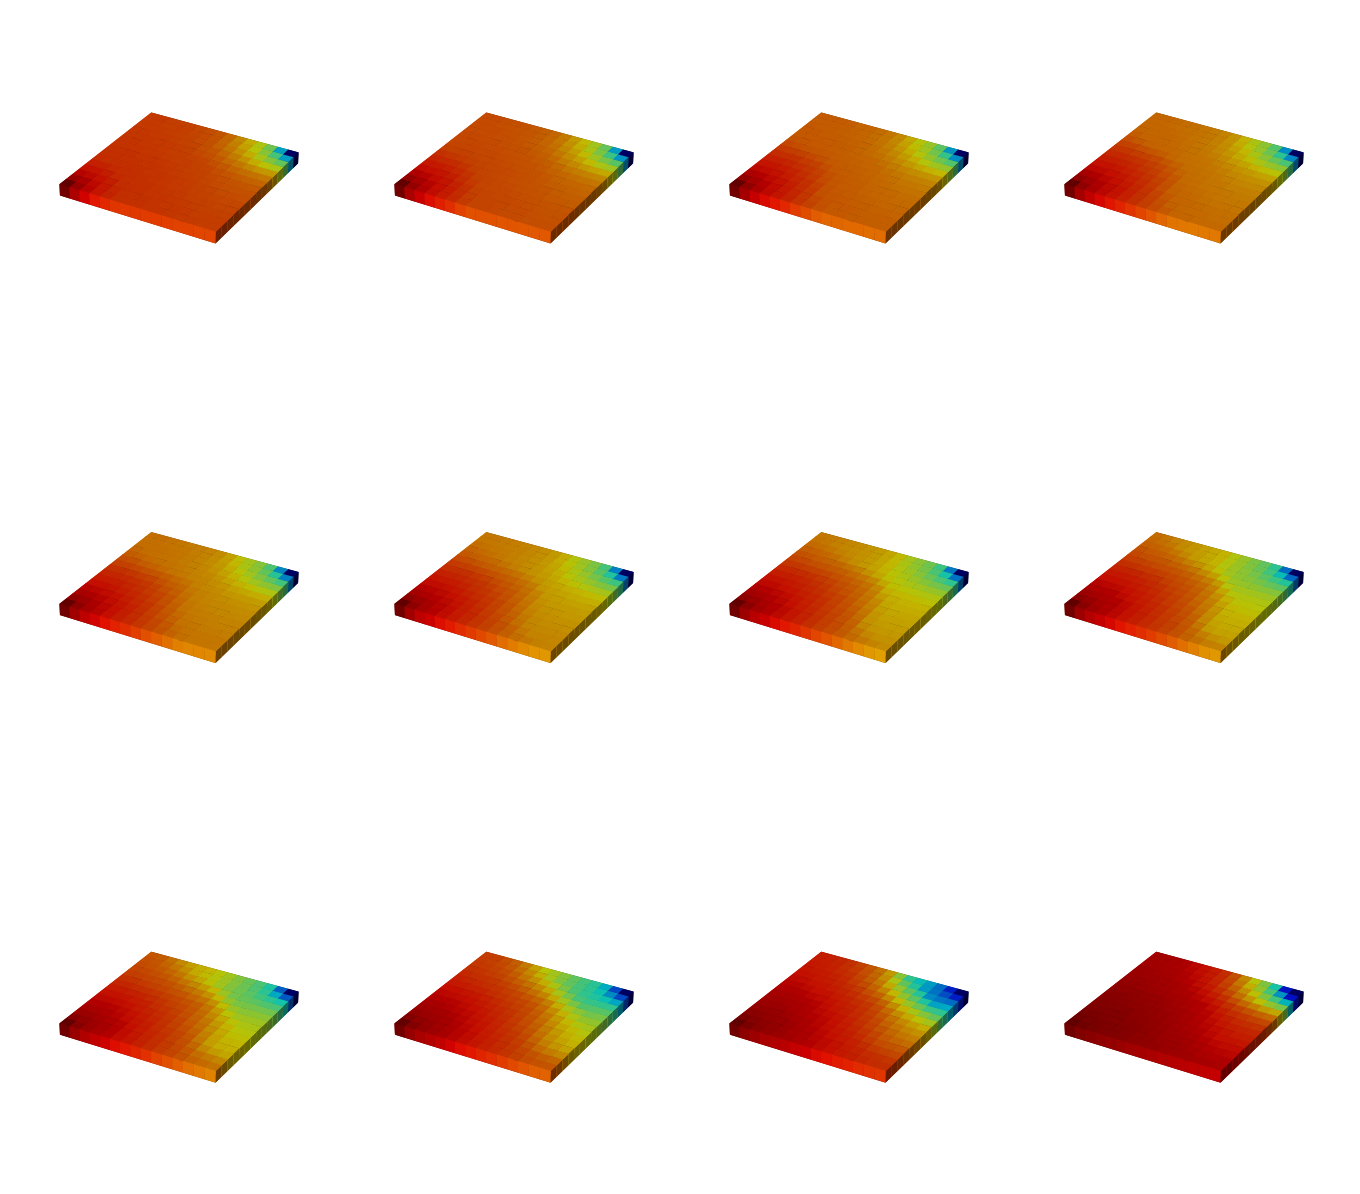

In [157]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure(figsize=(3.5,3.5), dpi = 400)
# Create sample data for the heatmap
for i in range(12):
    data = P_[int((i+1)*30/dt)+1].cpu().numpy()

    # Create meshgrid for X and Y
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    # Create a 3D plot
    ax = fig.add_subplot(3, 4, i+1, projection='3d')

    # Define constant height for all bars
    height = 1

    # Plot the bars for each data point
    ax.bar3d(X.flatten(), Y.flatten(), np.zeros_like(data.flatten()), 1, 1, 1, color=plt.cm.jet((data.flatten() - np.min(data.flatten()))/(np.max(data.flatten()) - np.min(data.flatten())) ), alpha=1)
    ax.set_box_aspect([15,15,1])
    
    # Set labels
    plt.axis(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.tight_layout()
plt.show()


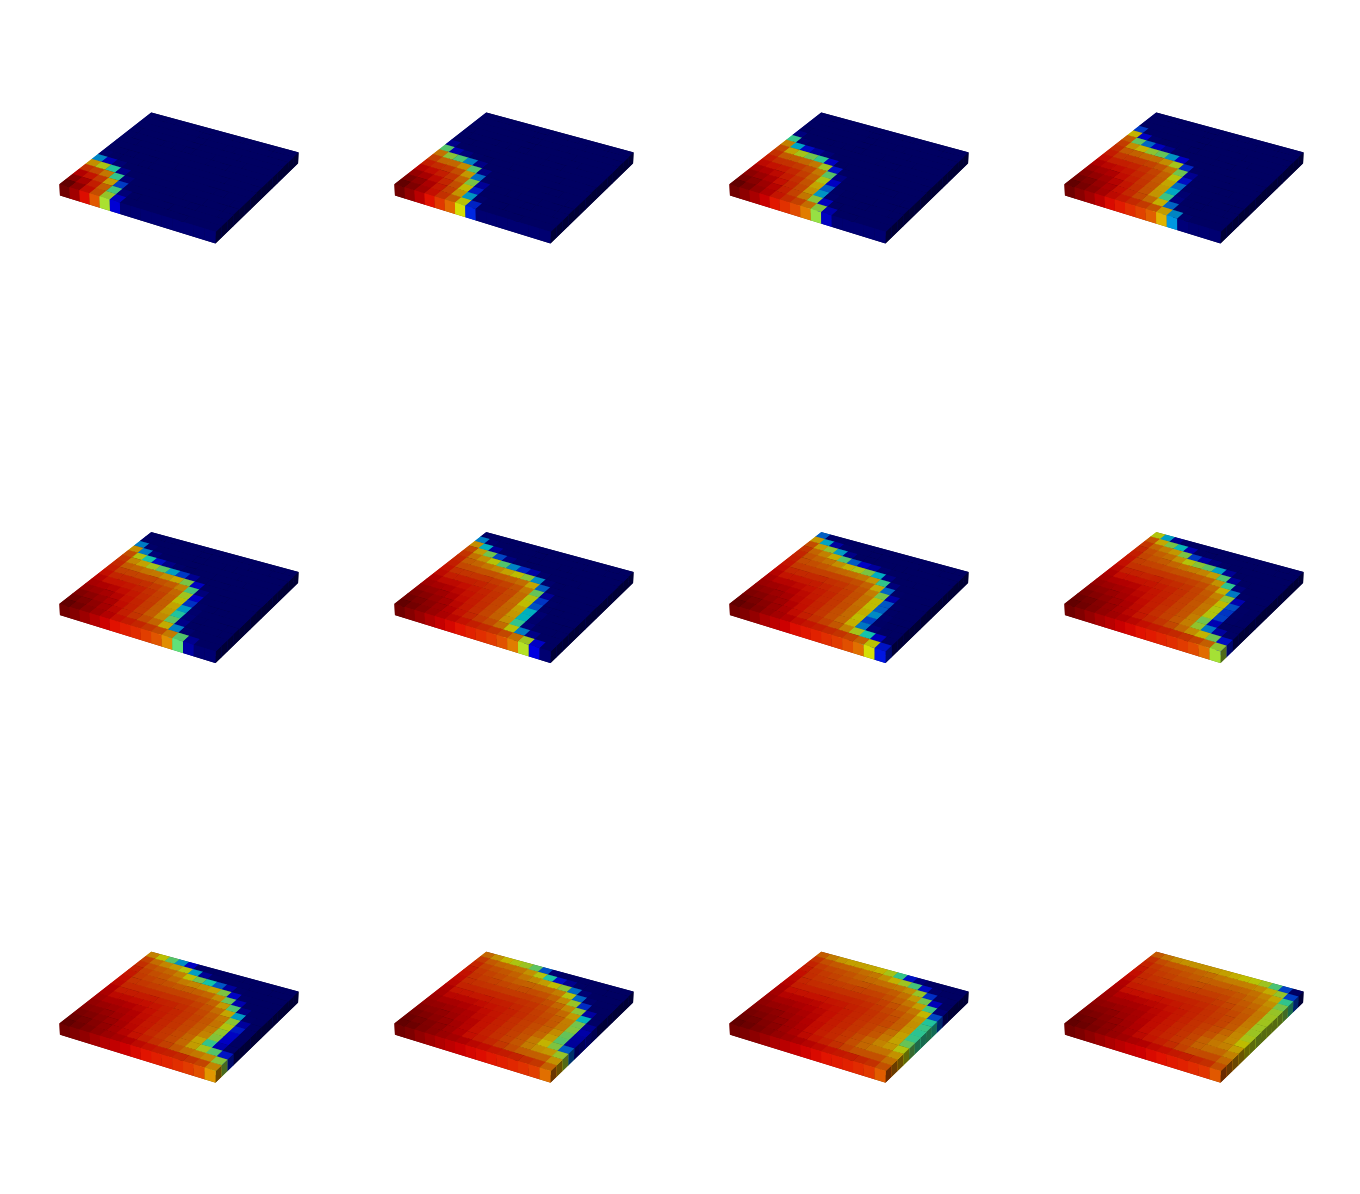

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure(figsize=(3.5,3.5), dpi = 400)
# Create sample data for the heatmap
for i in range(12):
    data = Sw_[int((i+1)*30/dt)+1].cpu().numpy()

    # Create meshgrid for X and Y
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    # Create a 3D plot
    ax = fig.add_subplot(3, 4, i+1, projection='3d')

    # Define constant height for all bars
    height = 1

    # Plot the bars for each data point
    ax.bar3d(X.flatten(), Y.flatten(), np.zeros_like(data.flatten()), 1, 1, 1, color=plt.cm.jet((data.flatten() - np.min(data.flatten()))/(np.max(data.flatten()) - np.min(data.flatten())) ), alpha=1)
    ax.set_box_aspect([15,15,1])
    
    # Set labels
    plt.axis(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.tight_layout()
plt.show()


# Comparison

In [233]:
Q_GT = []
for n in range(0, steps):
        P = P_[n]
        Sw = Sw_[n]
        q = PRODUCTION(C, P, Sw, Co = Co, Cw = Cw,K = K, S = S, rw  = rw, re = re, Well_Loc = Well_Loc, QinjW = QinjW, Pref = Pref, K1 = Kr1, K2 = Kr2, Somin = Somin, Somax = Somax, Swmax = Swmax, Swmin = Swmin)
        Q_GT.append(q)
Qo_GT = []
Qw_GT = []

for q in Q_GT:
    Qo_GT.append(q[0][-1,-1].cpu().numpy())
    Qw_GT.append(q[1][-1,-1].cpu().numpy())

Qo_GT = np.array(Qo_GT)
Qw_GT = np.array(Qw_GT)

In [234]:
P0 = torch.ones(1,15,15, device=device)*Pi
S0 = torch.ones(1,15,15, device=device)*Swi

In [235]:
P_pred_data_gat = torch.tensor(np.genfromtxt(r"C:\Users\YUSIFOH\NNs\GNN\DATA Generation copy\P_pred_data_gat.mat").reshape((-1, 15, 15)), dtype=torch.float, device=device)
P_pred_gat = torch.vstack((P0, P_pred_data_gat))
S_pred_data_gat = torch.tensor(np.genfromtxt(r"C:\Users\YUSIFOH\NNs\GNN\DATA Generation copy\S_pred_data_gat.mat").reshape((-1, 15, 15)), dtype=torch.float, device=device)
S_pred_gat = torch.vstack((S0, S_pred_data_gat))

In [236]:
Q_P_gat = []
for n in range(0, steps):
        P = P_pred_gat[n]
        Sw = S_pred_gat[n]
        q = PRODUCTION(C, P, Sw, Co = Co, Cw = Cw,K = K, S = S, rw  = rw, re = re, Well_Loc = Well_Loc, QinjW = QinjW, Pref = Pref, K1 = Kr1, K2 = Kr2, Somin = Somin, Somax = Somax, Swmax = Swmax, Swmin = Swmin)
        Q_P_gat.append(q)
Qo_P_gat = []
Qw_P_gat = []
for q in Q_P_gat:
    Qo_P_gat.append(q[0][-1,-1].cpu().numpy())
    Qw_P_gat.append(q[1][-1,-1].cpu().numpy())

Qo_P_gat = np.array(Qo_P_gat)
Qw_P_gat = np.array(Qw_P_gat)

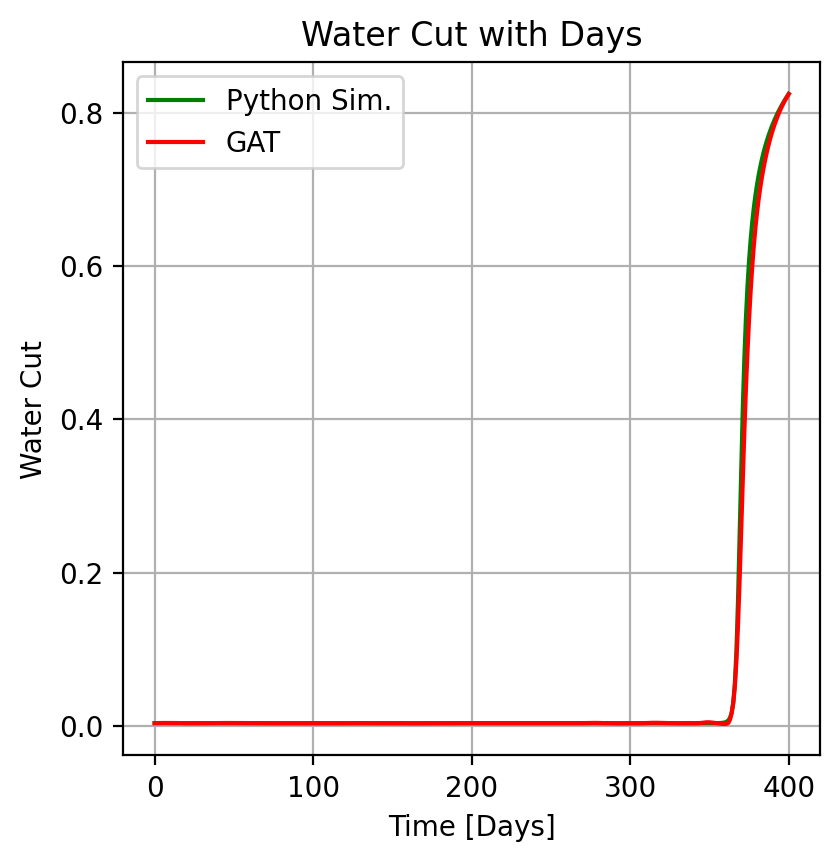

In [237]:
plt.figure(figsize = (4.5,4.5), dpi=200)
plt.plot((Qw_GT/(Qw_GT + Qo_GT)), color = 'green', label = 'Python Sim.')
plt.plot((Qw_P_gat/(Qw_P_gat + Qo_P_gat)), color = 'red', label = 'GAT')
plt.title('Water Cut with Days')
plt.xlabel('Time [Days]')
plt.ylabel('Water Cut')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\YUSIFOH\NNs\GNN\COMPARISON PLOTS\wc_gat.png', dpi = 1080)
plt.show()

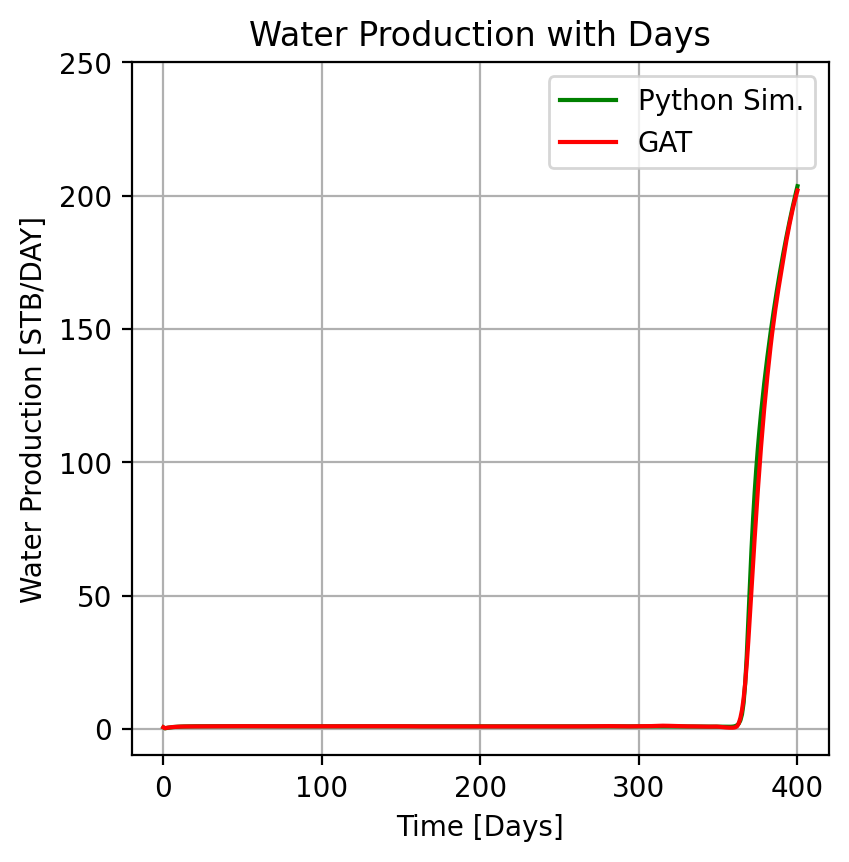

In [238]:
plt.figure(figsize = (4.5,4.5), dpi=200)
plt.plot(Qw_GT, color = 'green', label = 'Python Sim.')
plt.plot(Qw_P_gat, color ='red', label = 'GAT')
plt.yticks(np.linspace(0, 250, 6))
plt.title('Water Production with Days')
plt.xlabel('Time [Days]')
plt.ylabel('Water Production [STB/DAY]')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\YUSIFOH\NNs\GNN\COMPARISON PLOTS\wp_gat.png', dpi = 1080)

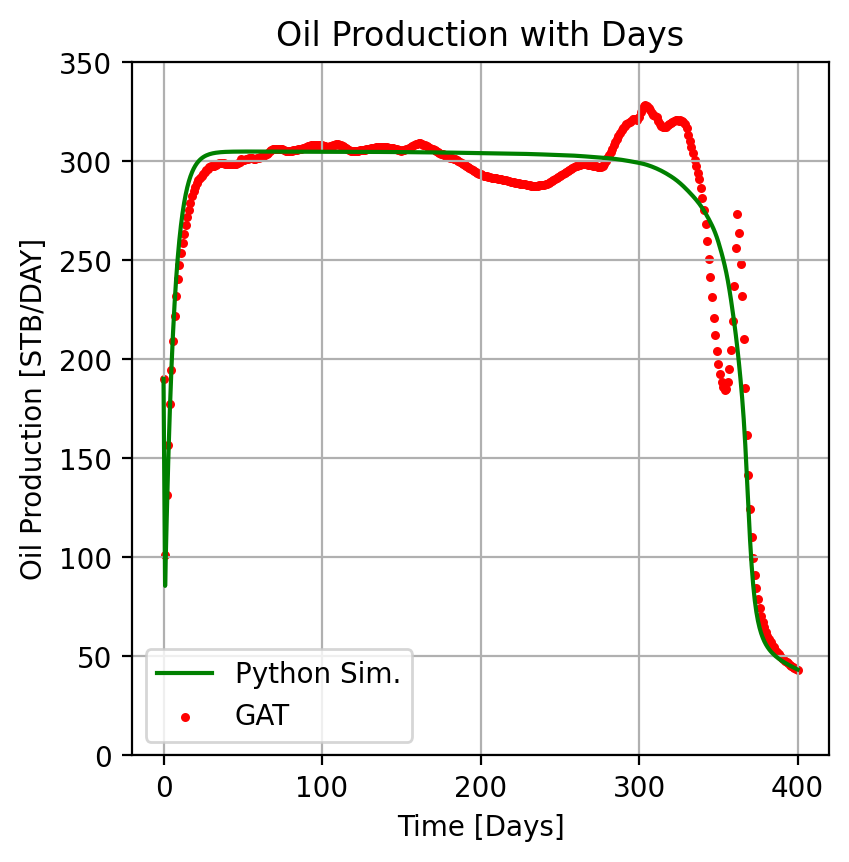

In [239]:
plt.figure(figsize = (4.5,4.5), dpi=200)
plt.plot(Qo_GT, color = 'green', label = 'Python Sim.')
plt.scatter(range(len(Qo_P_gat)),Qo_P_gat, color ='red', label = 'GAT', s = 5)
plt.yticks(np.linspace(0, 350, 8))
plt.title('Oil Production with Days')
plt.xlabel('Time [Days]')
plt.ylabel('Oil Production [STB/DAY]')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\YUSIFOH\NNs\GNN\COMPARISON PLOTS\op_gat.png', dpi = 1080)

In [165]:
AvP_ = torch.mean(torch.mean(P_, axis = 1), axis = 1)
AvSw_ = torch.mean(torch.mean(Sw_, axis = 1), axis = 1)
AvP_gat = torch.mean(torch.mean(P_pred_gat, axis = 1), axis = 1)
AvSw_gat = torch.mean(torch.mean(S_pred_gat, axis = 1), axis = 1)

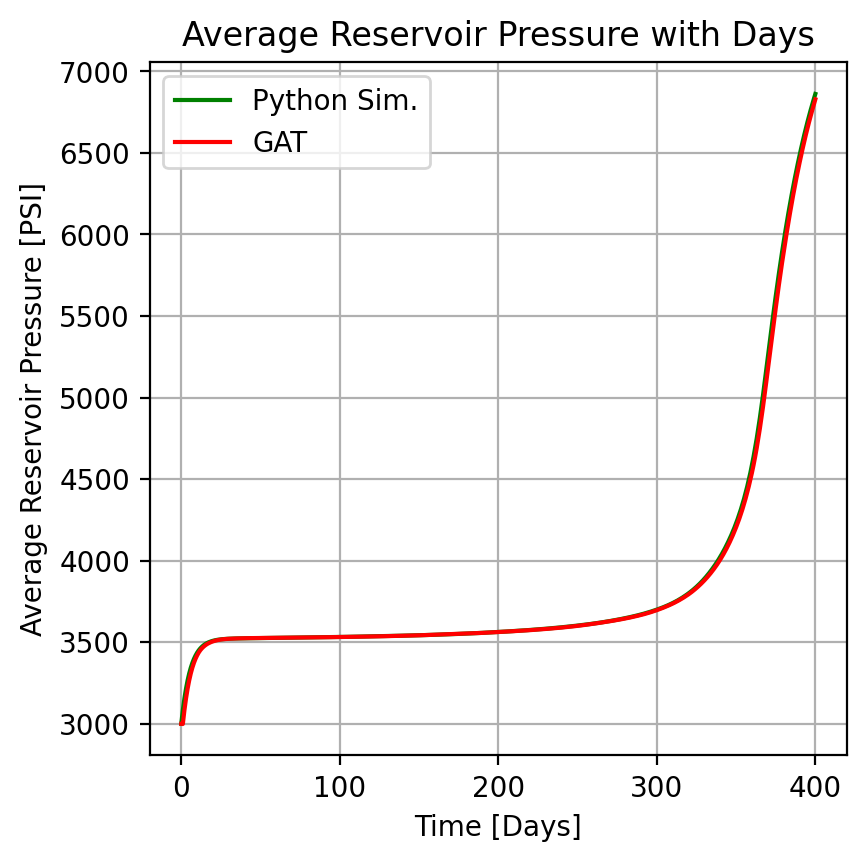

In [166]:
plt.figure(figsize = (4.5,4.5), dpi=200)
plt.plot(AvP_.cpu(), color = 'green', label = 'Python Sim.')
plt.plot(AvP_gat.cpu(), color ='red', label = 'GAT')
plt.title('Average Reservoir Pressure with Days')
plt.xlabel('Time [Days]')
plt.ylabel('Average Reservoir Pressure [PSI]')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\YUSIFOH\NNs\GNN\COMPARISON PLOTS\av_p_gat.png', dpi = 1080)

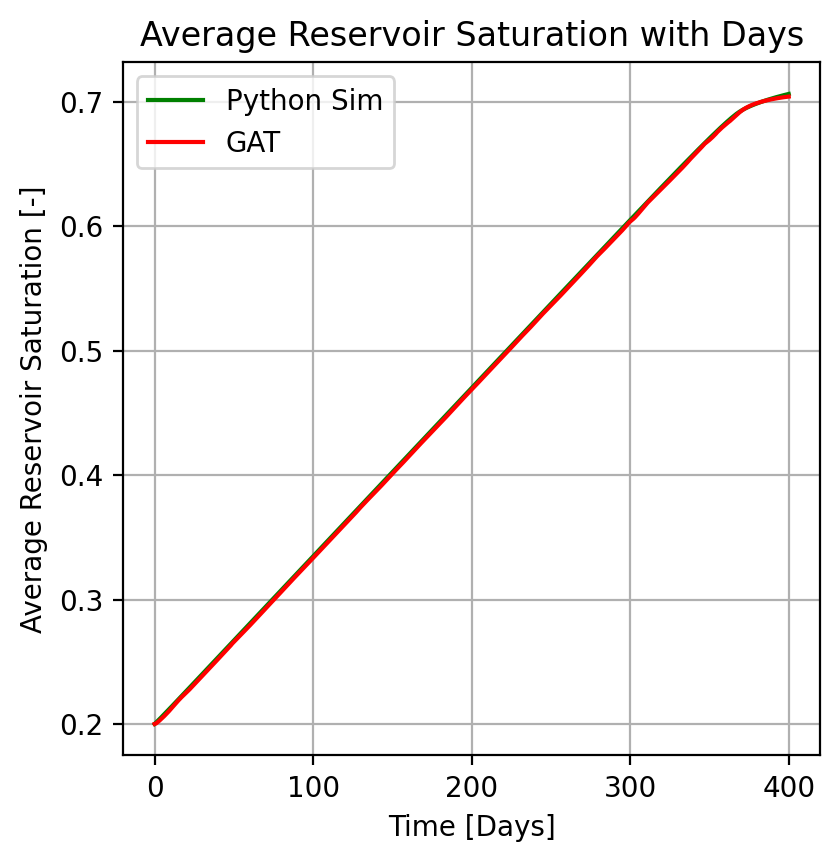

In [167]:
plt.figure(figsize = (4.5,4.5), dpi=200)
plt.plot(AvSw_.cpu(), color = 'green', label = 'Python Sim')
plt.plot(AvSw_gat.cpu(), color ='red', label = 'GAT')
plt.title('Average Reservoir Saturation with Days')
plt.xlabel('Time [Days]')
plt.ylabel('Average Reservoir Saturation [-]')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\YUSIFOH\NNs\GNN\COMPARISON PLOTS\av_s_gat.png', dpi = 1080)